In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [11]:
train_dir_path = "train/"
test_dir_path = "test/"

# load the train, test, sample csv [reset]
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test_files.csv")
sample_submit_df = pd.read_csv("sample_submission.csv")
# check the additional metadata
metadata = pd.read_csv("additional_metadata.csv")

# print the shape
print(train_df.info())
print(test_df.info())
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   patient_id   59 non-null     object
 1   AS           59 non-null     int64 
 2   AR           59 non-null     int64 
 3   MR           59 non-null     int64 
 4   MS           59 non-null     int64 
 5   N            59 non-null     int64 
 6   recording_1  59 non-null     object
 7   recording_2  59 non-null     object
 8   recording_3  59 non-null     object
 9   recording_4  59 non-null     object
 10  recording_5  59 non-null     object
 11  recording_6  59 non-null     object
 12  recording_7  59 non-null     object
 13  recording_8  59 non-null     object
dtypes: int64(5), object(9)
memory usage: 6.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0

In [12]:
# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

# import a sample audio file
audio_file = train_dir_path + "002_sit_Aor.wav"
aud, sr = librosa.load(audio_file, sr=None)
print(f"shape of the audio file: {aud.shape}")
print(f"sample rate: {sr}")

# length of the audio file
print(f"length of the audio file: {len(aud)/sr} seconds")

shape of the audio file: (80000,)
sample rate: 4000
length of the audio file: 20.0 seconds


In [13]:
# each audio file is 20 seconds long
# cut each audio file into 4 parts of 5 seconds each
# then add those 4 parts to the dataframe, instead of the original audio file

# create a function to cut the audio file into 4 parts
def segment_audio_files(file, n_segments=4, segment_length=5):
    # load the audio file
    aud, sr = librosa.load(file, sr=None)
    # get the length of the audio file
    length = len(aud)
    # get the length of each segment
    segment_length = sr * segment_length
    # get the number of samples per segment
    samples_per_segment = length // n_segments
    # get the starting point of each segment
    start = 0
    # get the ending point of each segment
    end = samples_per_segment
    # create an empty list to store the segments
    segments = []
    # loop through the audio file and get the segments
    for _ in range(n_segments):
        segment = aud[start:end]
        segments.append(segment)
        start = end
        end = start + samples_per_segment
    return segments
    

In [14]:
# # test the function
segments = segment_audio_files(audio_file)
# print the length of the segments and sr
for segment in segments:
    print(f"length of the segment: {len(segment)/sr} seconds")
    print(f"sample rate: {sr}")

length of the segment: 5.0 seconds
sample rate: 4000
length of the segment: 5.0 seconds
sample rate: 4000
length of the segment: 5.0 seconds
sample rate: 4000
length of the segment: 5.0 seconds
sample rate: 4000


In [15]:
# # plot the original audio file
# plt.figure(figsize=(14, 5))
# librosa.display.waveshow(aud, sr=sr, color="green")
# plt.title("Original Audio File")
# # plt.show()

# # plot the segments
# plt.figure(figsize=(14, 5))
# for i, segment in enumerate(segments):
#     plt.subplot(4, 1, i+1)
#     librosa.display.waveshow(segment, sr=sr, color="green")
#     plt.title(f"Segment {i+1}")

# plt.tight_layout()
# plt.show()

In [16]:
# convert all train and test audio files into segments
record_classes = ["recording_1", "recording_2", "recording_3", "recording_4", "recording_5", "recording_6", "recording_7", "recording_8"]
labels = ["AS", "AR", "MR", "MS", "N"]

# create a new dataframe that has the same headers as the train dataframe
new_train_df = pd.DataFrame(columns=train_df.columns)
# print(new_train_df)
temp = {}

# process each row in the train dataframe
for i, row in train_df.iterrows():
    # extract the labels first 
    label = train_df.iloc[i][1:6] 
    # print(label)
    # get the audio file from each of the 8 columns
    for col in record_classes:
        audio_file = train_dir_path + row[col] + ".wav"
        segments = segment_audio_files(audio_file)
        # now we have 4 segments all of which has the similar labels
        temp[col] = segments
    # print(len(temp))
    # now we have 8 segments for each row
    # we need to add each segment to the new dataframe
    for i in range(4):
        new_row = row.copy()
        for col in record_classes:
            new_row[col] = temp[col][i]
        new_train_df = new_train_df._append(new_row, ignore_index=True)
train_df = new_train_df

In [17]:
# # do the same for test dataframe
# new_test_df = pd.DataFrame(columns=test_df.columns)
# temp = {}

# # process each row in the test dataframe
# for i, row in test_df.iterrows():
#     # get the audio file from each of the 8 columns
#     for col in record_classes:
#         audio_file = test_dir_path + row[col] + ".wav"
#         segments = segment_audio_files(audio_file)
#         # now we have 4 segments all of which has the similar labels
#         temp[col] = segments
#     # now we have 8 segments for each row
#     # we need to add each segment to the new dataframe
#     for i in range(4):
#         new_row = row.copy()
#         for col in record_classes:
#             new_row[col] = temp[col][i]
#         new_test_df = new_test_df._append(new_row, ignore_index=True)
# test_df = new_test_df

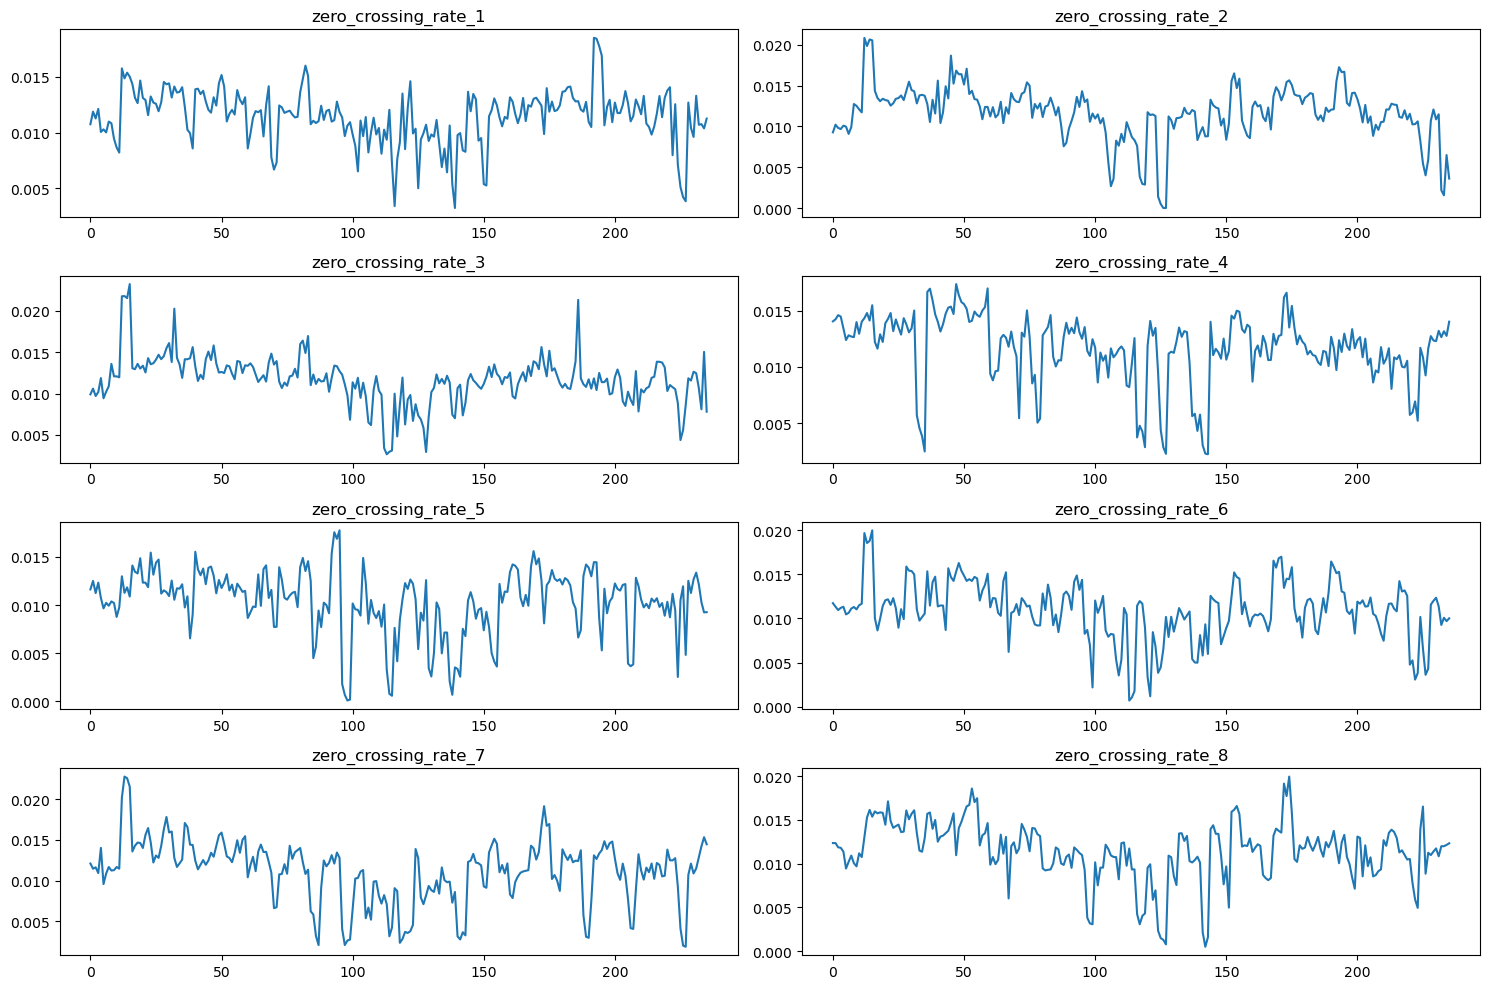

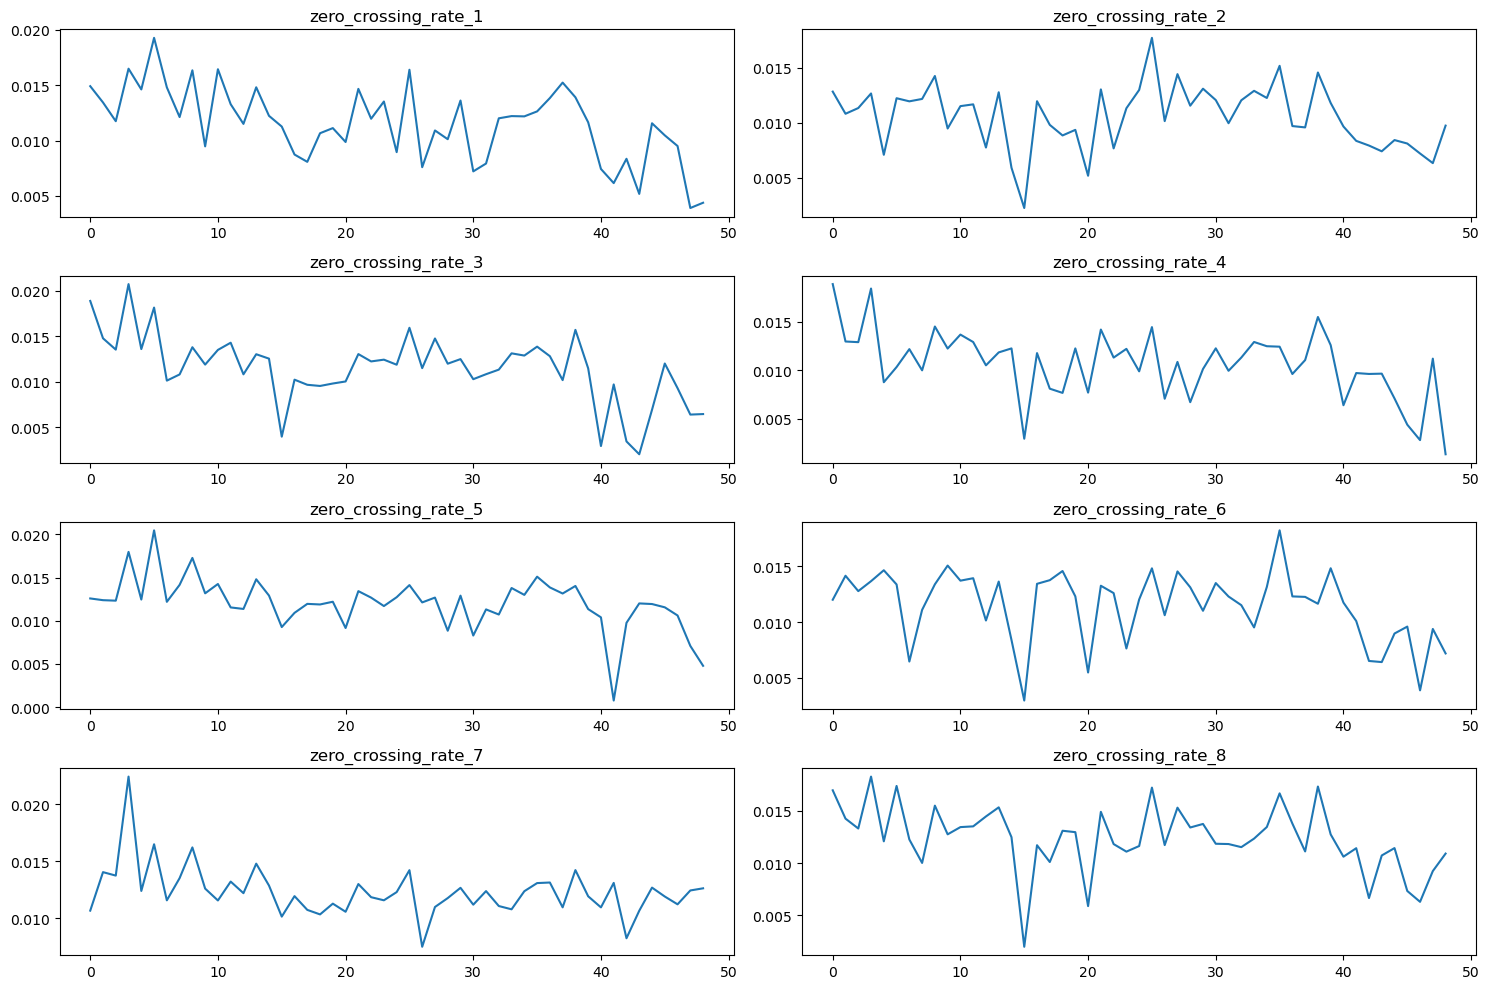

In [18]:
# 1. zero crossing rate column for all the audio files
zero_crossing_rate_list = []
# create slot for 8 plots in a single figure
plt.figure(figsize=(15, 10))
for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"zero_crossing_rate_{i+1}"
    zero_crossing_rate = []
    for aud in train_df[column_name]:
        # file_path = train_dir_path + audio_file + ".wav"
        # aud, sr = librosa.load(file_path, sr=None)
        zero_crossing_rate.append(librosa.feature.zero_crossing_rate(np.array(aud), frame_length=1024, hop_length=256).mean())
    zero_crossing_rate_list.append(zero_crossing_rate)
    train_df[new_column_name] = zero_crossing_rate
    # plot the newly added column and put all the plots in a single figure
    # keep some gaps between the plots
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(zero_crossing_rate)
    plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
zero_crossing_rate_list = []
for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"zero_crossing_rate_{i+1}"
    zero_crossing_rate = []
    for audio_file in test_df[column_name]:
        file_path = test_dir_path + audio_file + ".wav"
        aud, sr = librosa.load(file_path, sr=None)
        zero_crossing_rate.append(librosa.feature.zero_crossing_rate(aud, frame_length=1024, hop_length=256).mean())
    zero_crossing_rate_list.append(zero_crossing_rate)
    test_df[new_column_name] = zero_crossing_rate
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(zero_crossing_rate)
    plt.tight_layout()
plt.show()



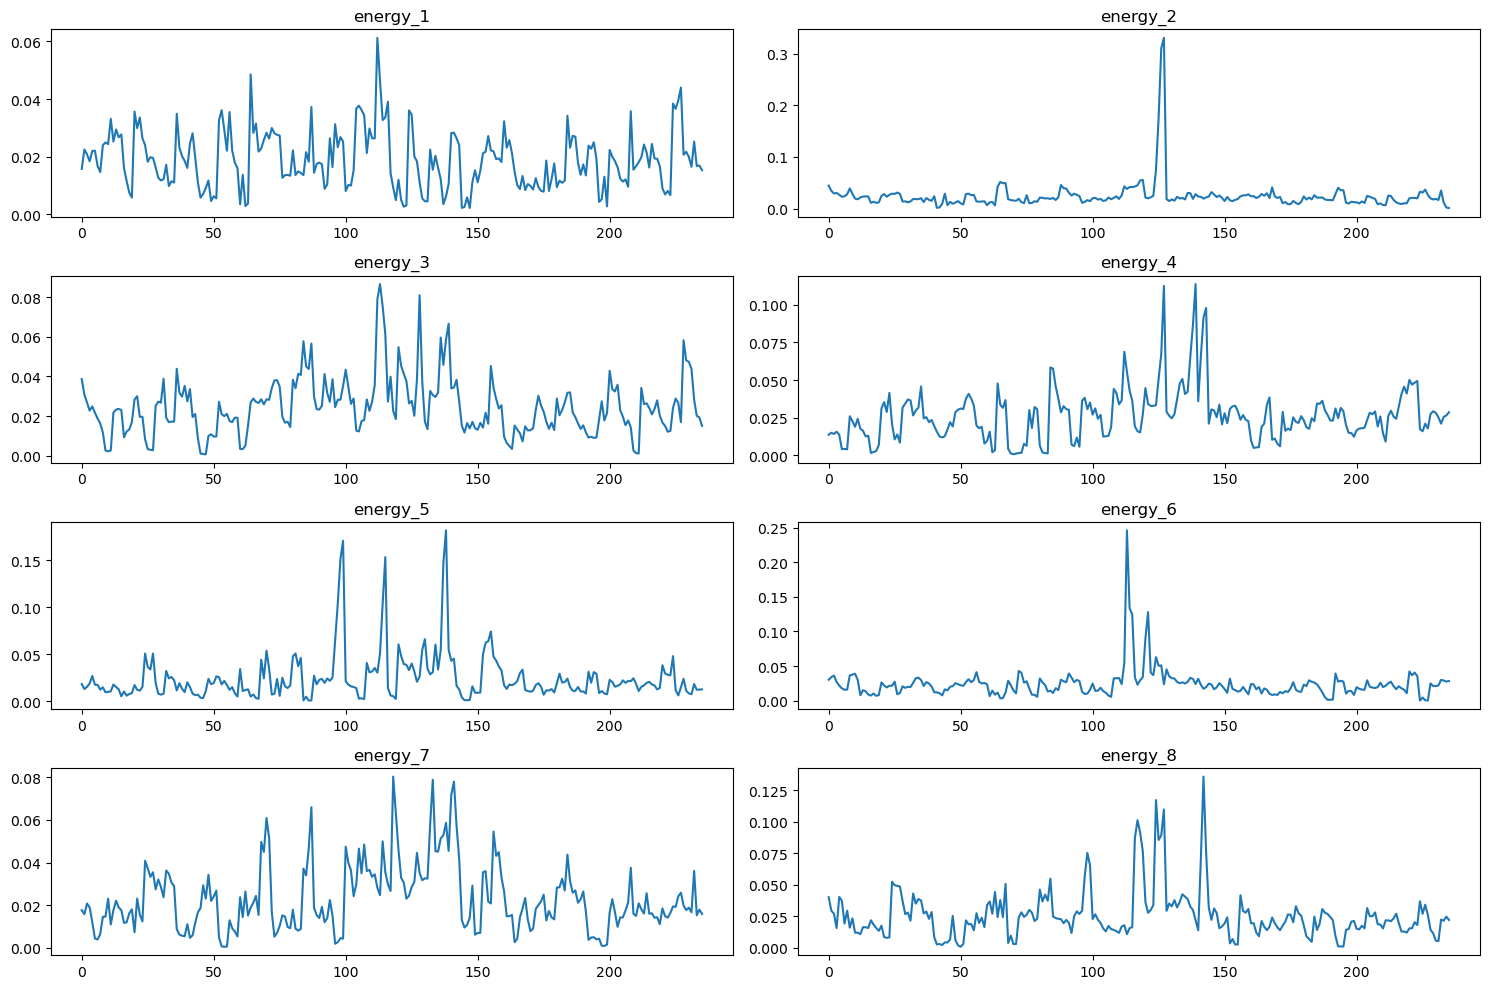

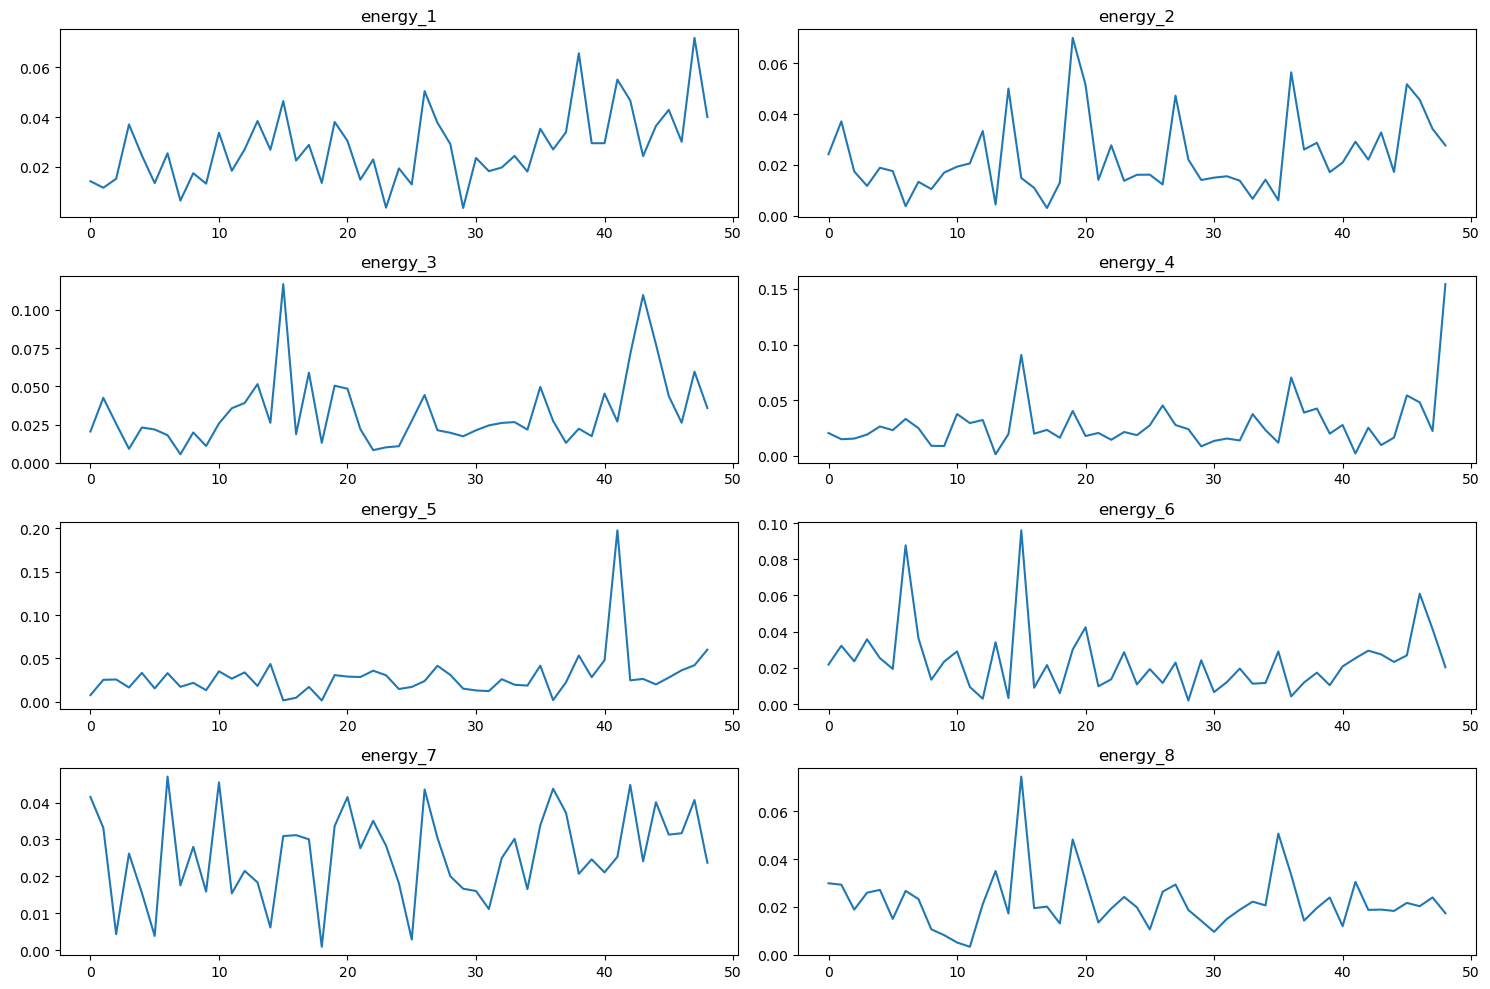

In [19]:
# 2. energy column for all the audio files
energy_list = []
plt.figure(figsize=(15, 10))
for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"energy_{i+1}"
    energy = []
    for aud in train_df[column_name]:
        energy.append((np.sum(aud**2))/len(aud))
    energy_list.append(energy)
    train_df[new_column_name] = energy
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(energy)
    plt.tight_layout()

plt.show()

energy_list = []
plt.figure(figsize=(15, 10))
for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"energy_{i+1}"
    energy = []
    for audio_file in test_df[column_name]:
        file_path = test_dir_path + audio_file + ".wav"
        aud, sr = librosa.load(file_path, sr=None)
        energy.append((np.sum(aud**2))/len(aud))
    energy_list.append(energy)
    test_df[new_column_name] = energy
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(energy)
    plt.tight_layout()

plt.show()

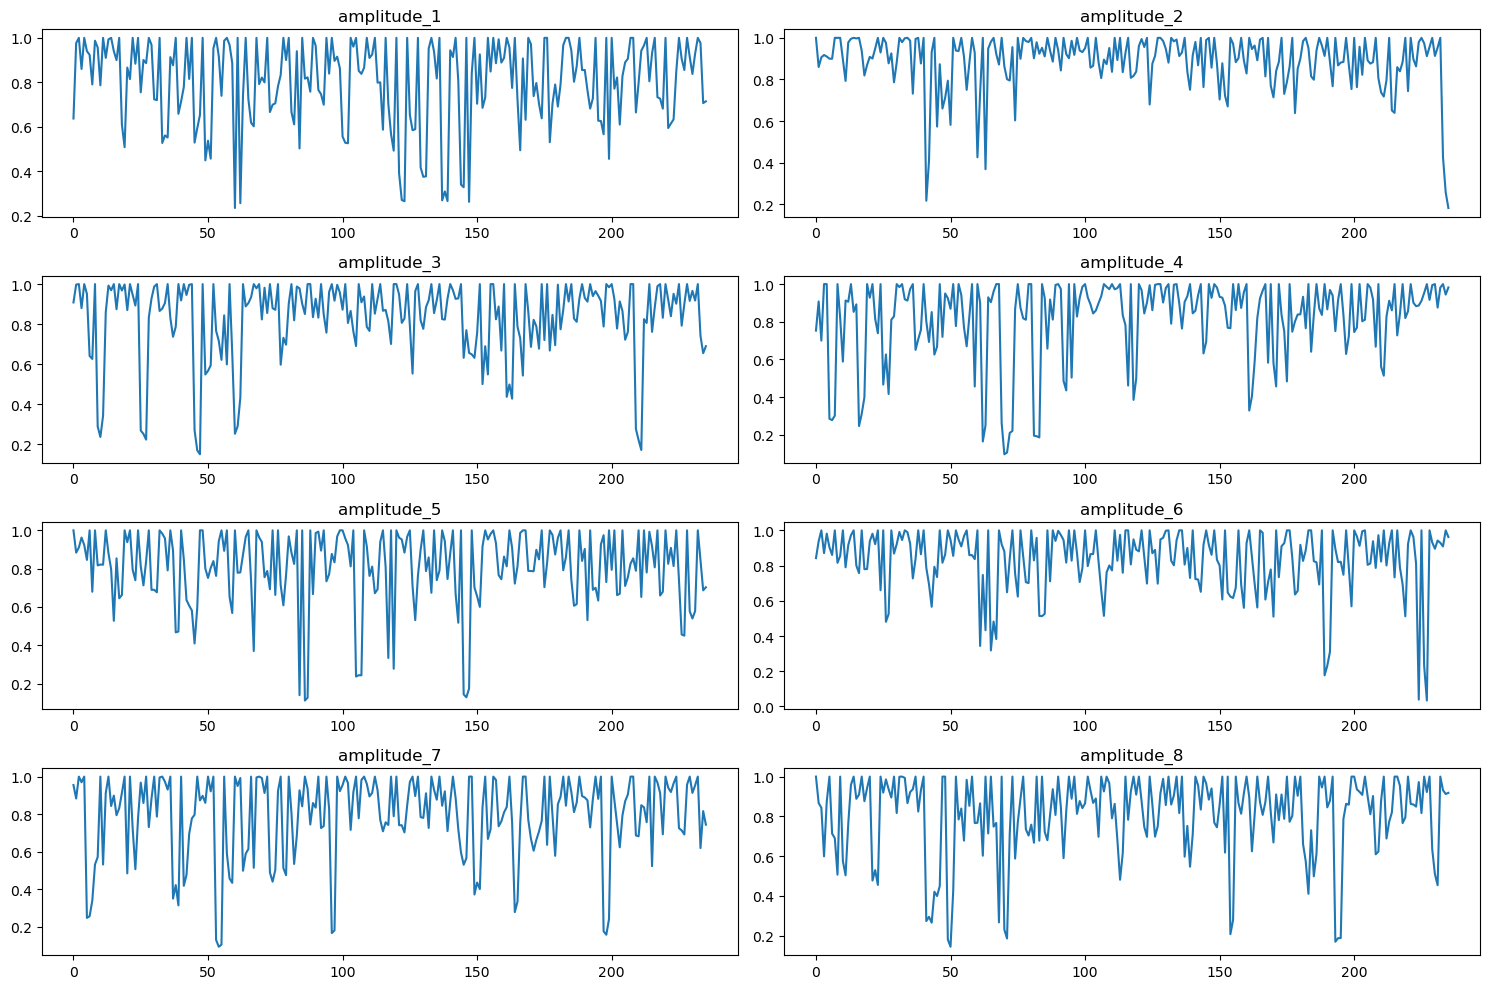

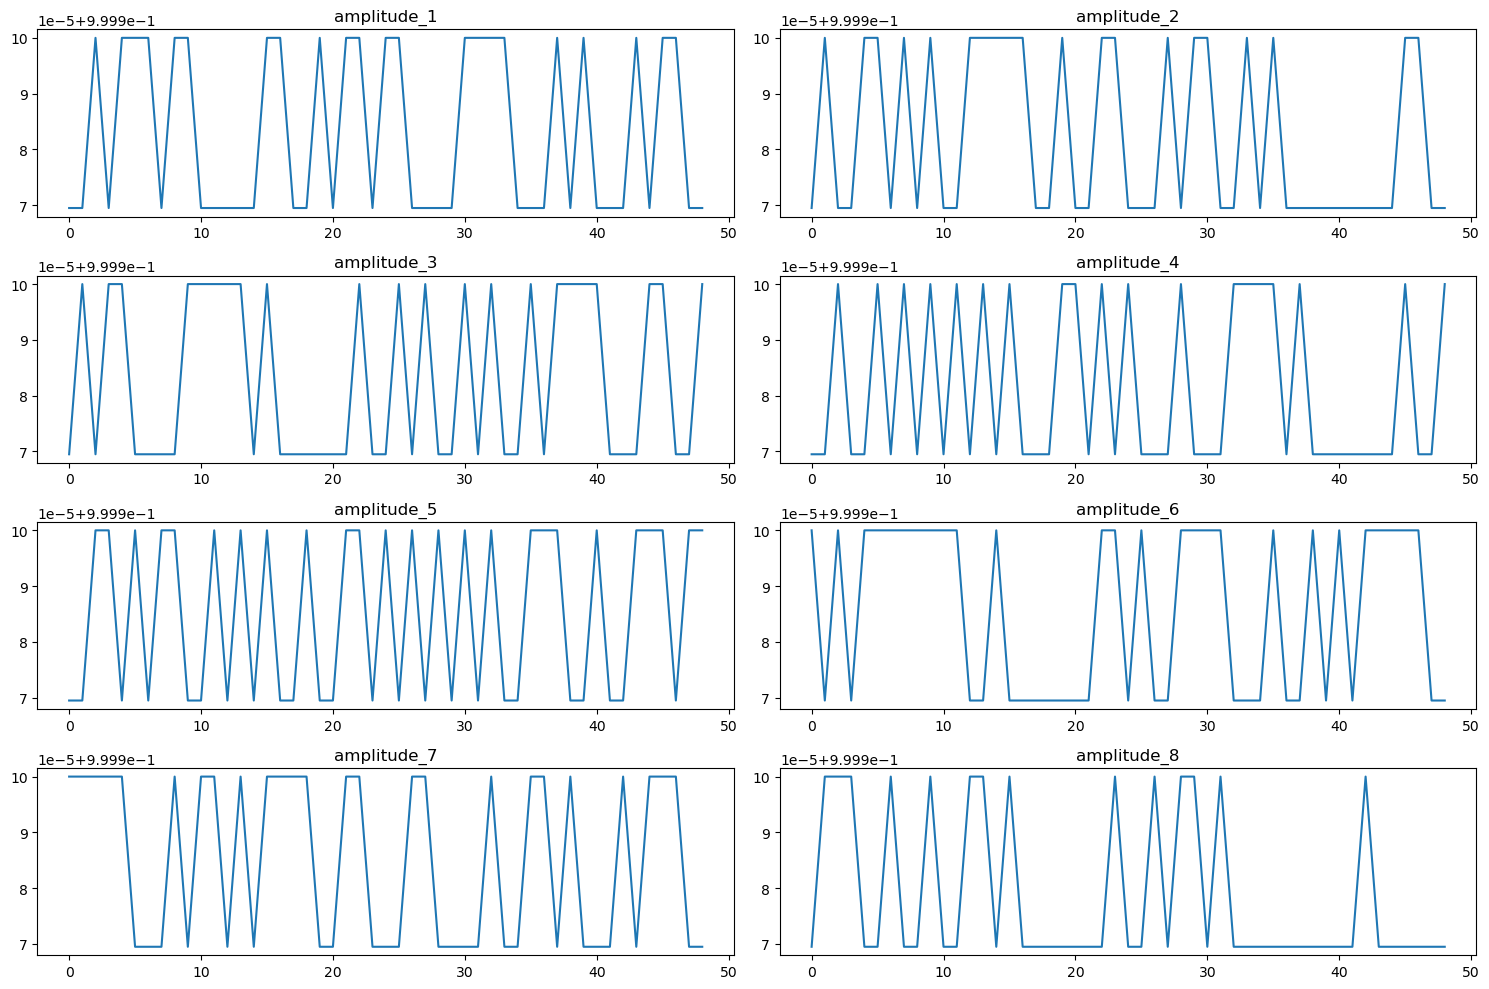

In [20]:
# 3. amplitude for all the audio files
amplitude_list = []
plt.figure(figsize=(15, 10))
for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"amplitude_{i+1}"
    amplitude = []
    for aud in train_df[column_name]:
        amplitude.append(np.max(np.abs(aud)))
    amplitude_list.append(amplitude)
    train_df[new_column_name] = amplitude
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(amplitude)
    plt.tight_layout()

plt.show()

amplitude_list = []
plt.figure(figsize=(15, 10))
for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"amplitude_{i+1}"
    amplitude = []
    for audio_file in test_df[column_name]:
        file_path = test_dir_path + audio_file + ".wav"
        aud, sr = librosa.load(file_path, sr=None)
        amplitude.append(np.max(np.abs(aud)))
    amplitude_list.append(amplitude)
    test_df[new_column_name] = amplitude
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(amplitude)
    plt.tight_layout()

plt.show()

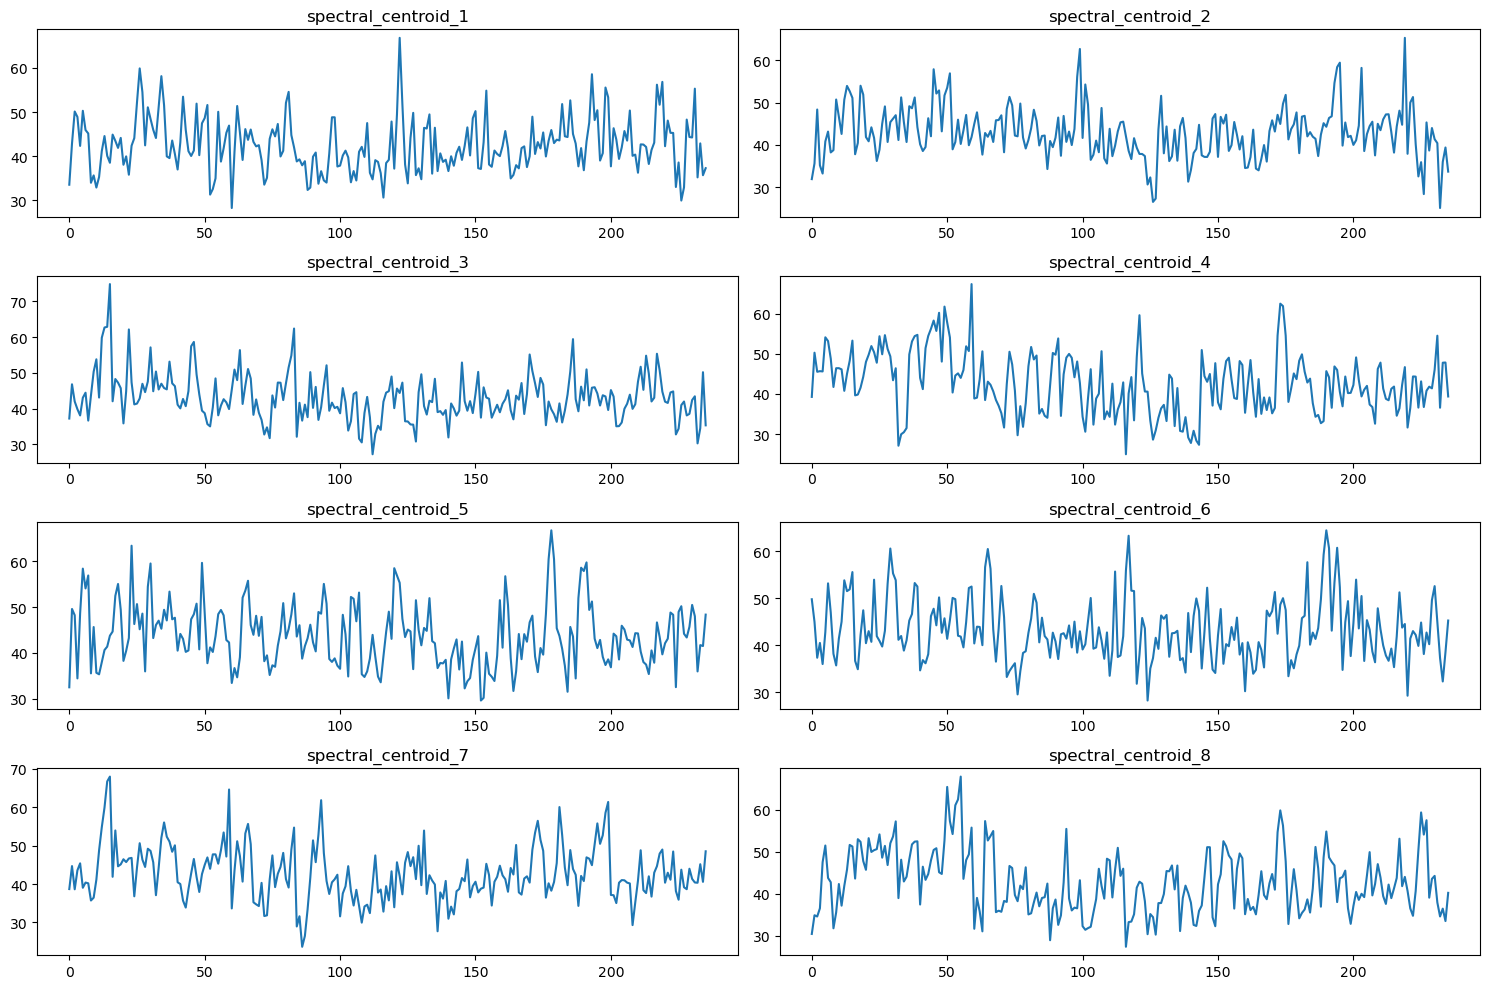

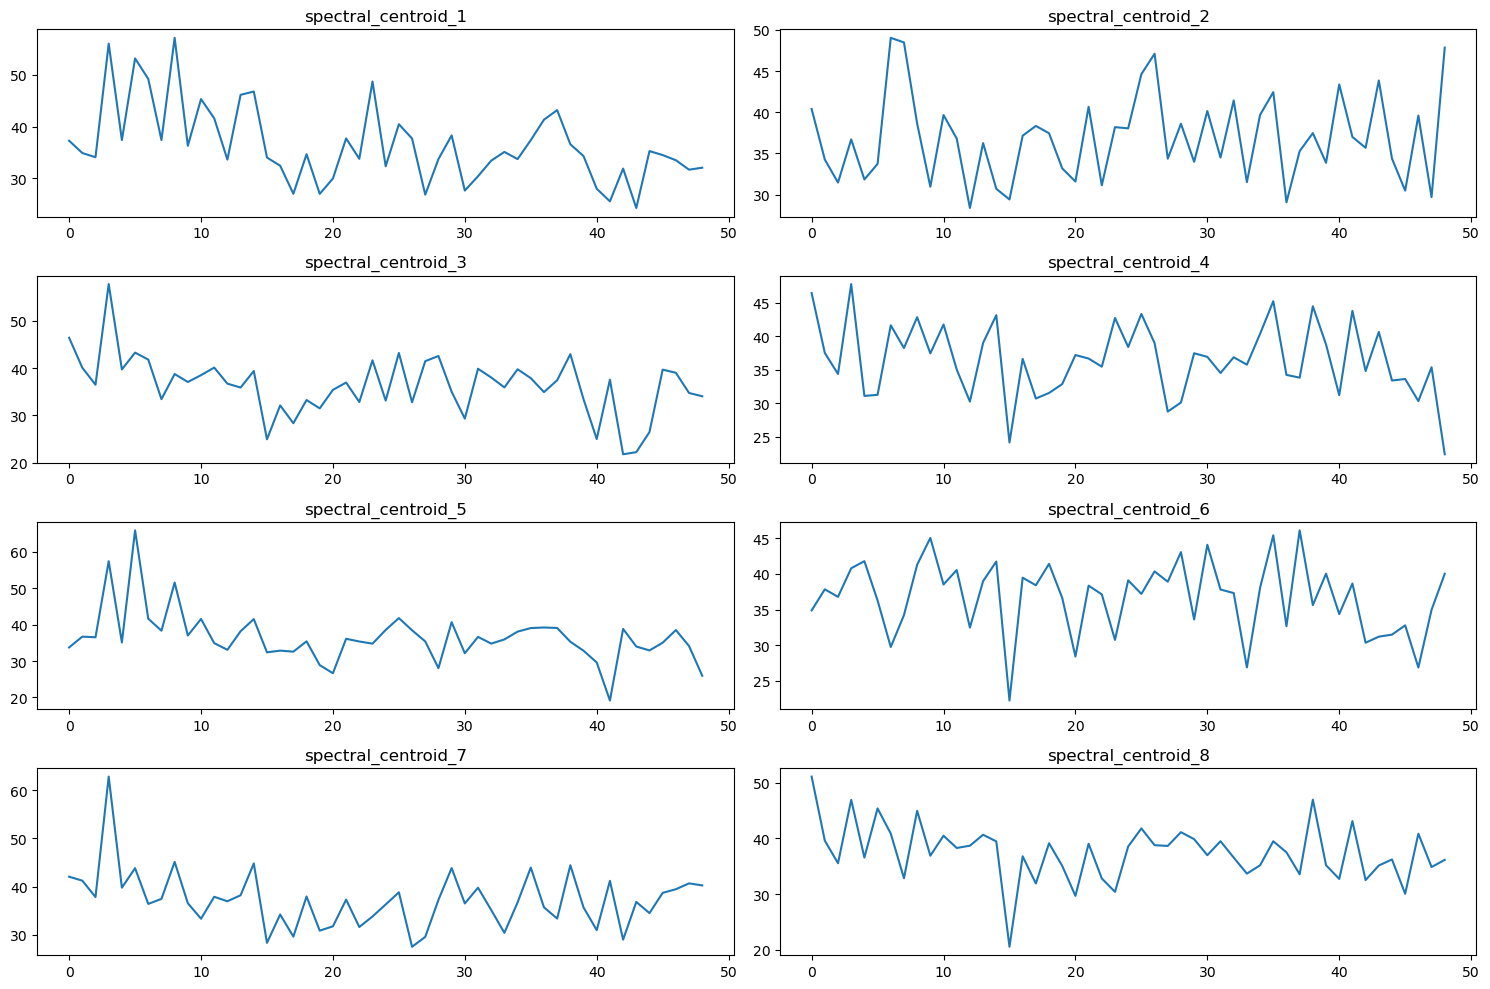

In [21]:
# 4. spectral centroid column for all the audio files
spectral_centroid_list = []
plt.figure(figsize=(15, 10))

for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"spectral_centroid_{i+1}"
    spectral_centroid = []
    for aud in train_df[column_name]:
        # file_path = train_dir_path + audio_file + ".wav"
        # aud, sr = librosa.load(file_path, sr=None)
        spectral_centroid.append(librosa.feature.spectral_centroid(y=np.array(aud), sr=sr).mean())
    spectral_centroid_list.append(spectral_centroid)
    train_df[new_column_name] = spectral_centroid
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(spectral_centroid)
    plt.tight_layout()
plt.show()


spectral_centroid_list = []
plt.figure(figsize=(15, 10))

for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"spectral_centroid_{i+1}"
    spectral_centroid = []
    for audio_file in test_df[column_name]:
        file_path = test_dir_path + audio_file + ".wav"
        aud, sr = librosa.load(file_path, sr=None)
        spectral_centroid.append(librosa.feature.spectral_centroid(y=aud, sr=sr).mean())
    spectral_centroid_list.append(spectral_centroid)
    test_df[new_column_name] = spectral_centroid
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(spectral_centroid)
    plt.tight_layout()
plt.show()

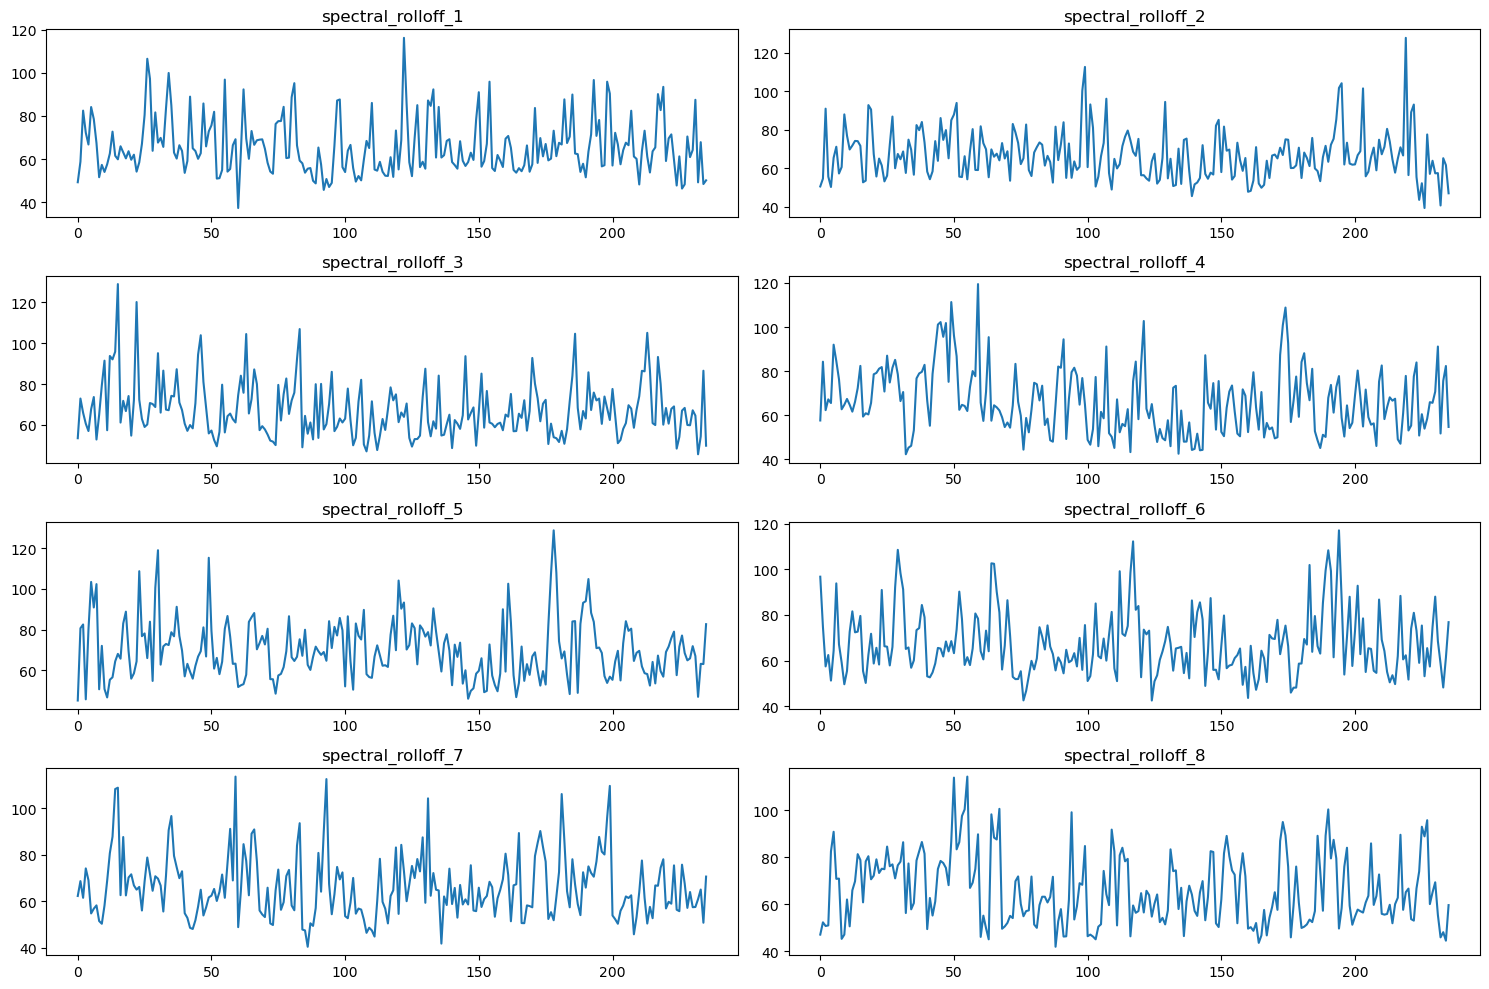

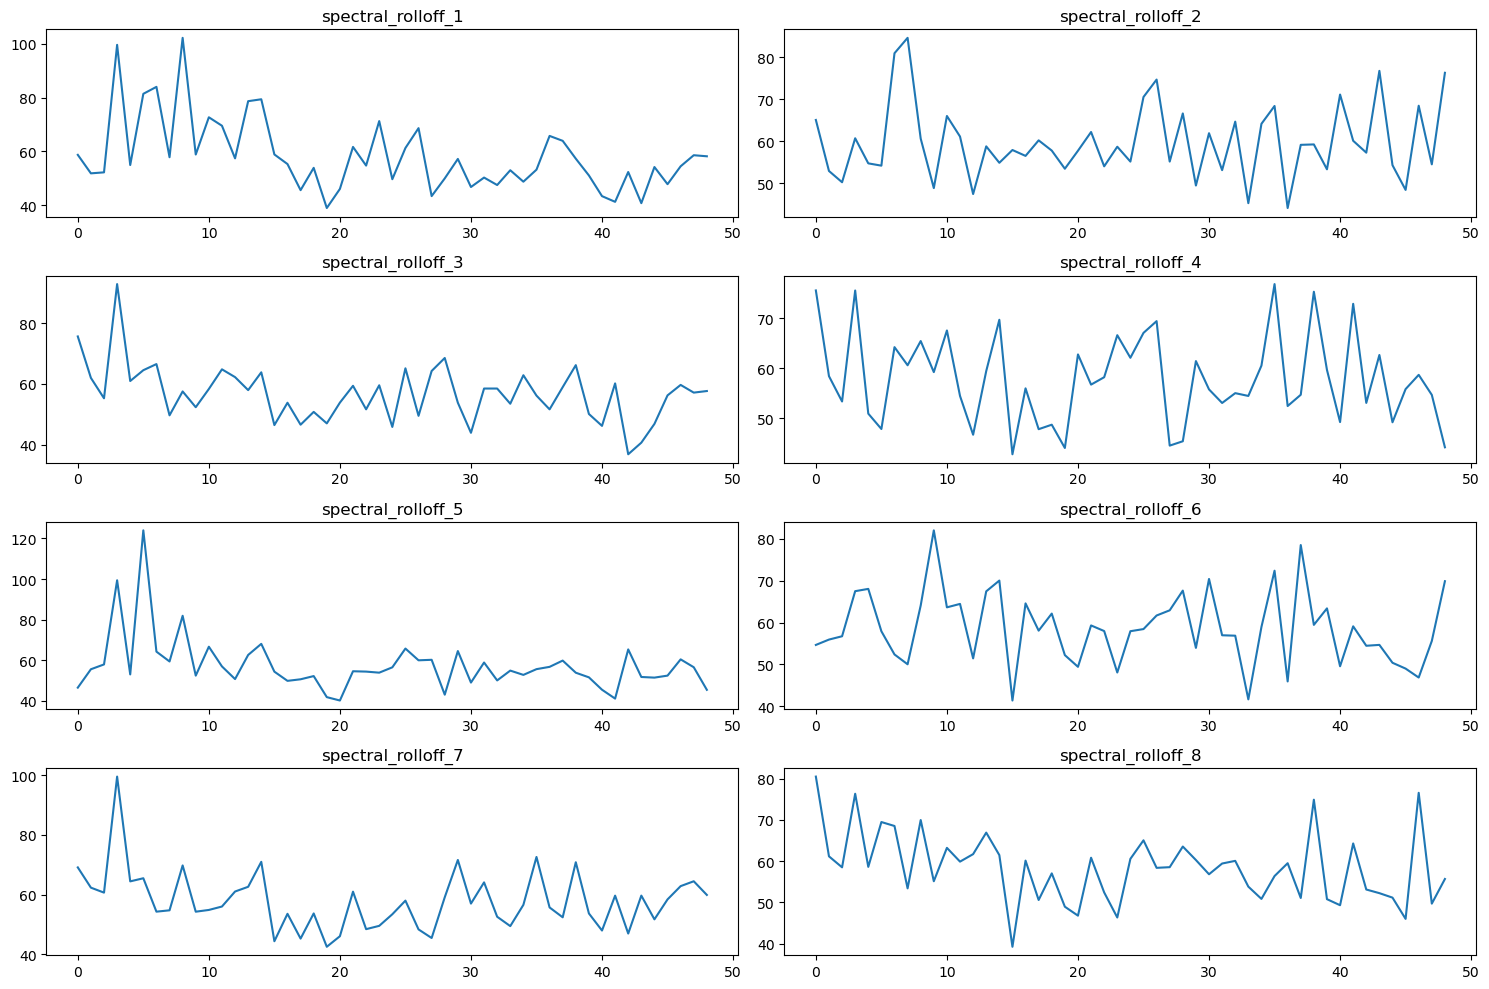

In [22]:
# 5. spectral roll-off column for all the audio files
spectral_rolloff_list = []
plt.figure(figsize=(15, 10))

for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"spectral_rolloff_{i+1}"
    spectral_rolloff = []
    for aud in train_df[column_name]:
        # file_path = train_dir_path + audio_file + ".wav"
        # aud, sr = librosa.load(file_path, sr=None)
        spectral_rolloff.append(librosa.feature.spectral_rolloff(y=np.array(aud), sr=sr).mean())
    spectral_rolloff_list.append(spectral_rolloff)
    train_df[new_column_name] = spectral_rolloff
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(spectral_rolloff)
    plt.tight_layout()
plt.show()


spectral_rolloff_list = []
plt.figure(figsize=(15, 10))

for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"spectral_rolloff_{i+1}"
    spectral_rolloff = []
    for audio_file in test_df[column_name]:
        file_path = test_dir_path + audio_file + ".wav"
        aud, sr = librosa.load(file_path, sr=None)
        spectral_rolloff.append(librosa.feature.spectral_rolloff(y=aud, sr=sr).mean())
    spectral_rolloff_list.append(spectral_rolloff)
    test_df[new_column_name] = spectral_rolloff
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(spectral_rolloff)
    plt.tight_layout()
plt.show()

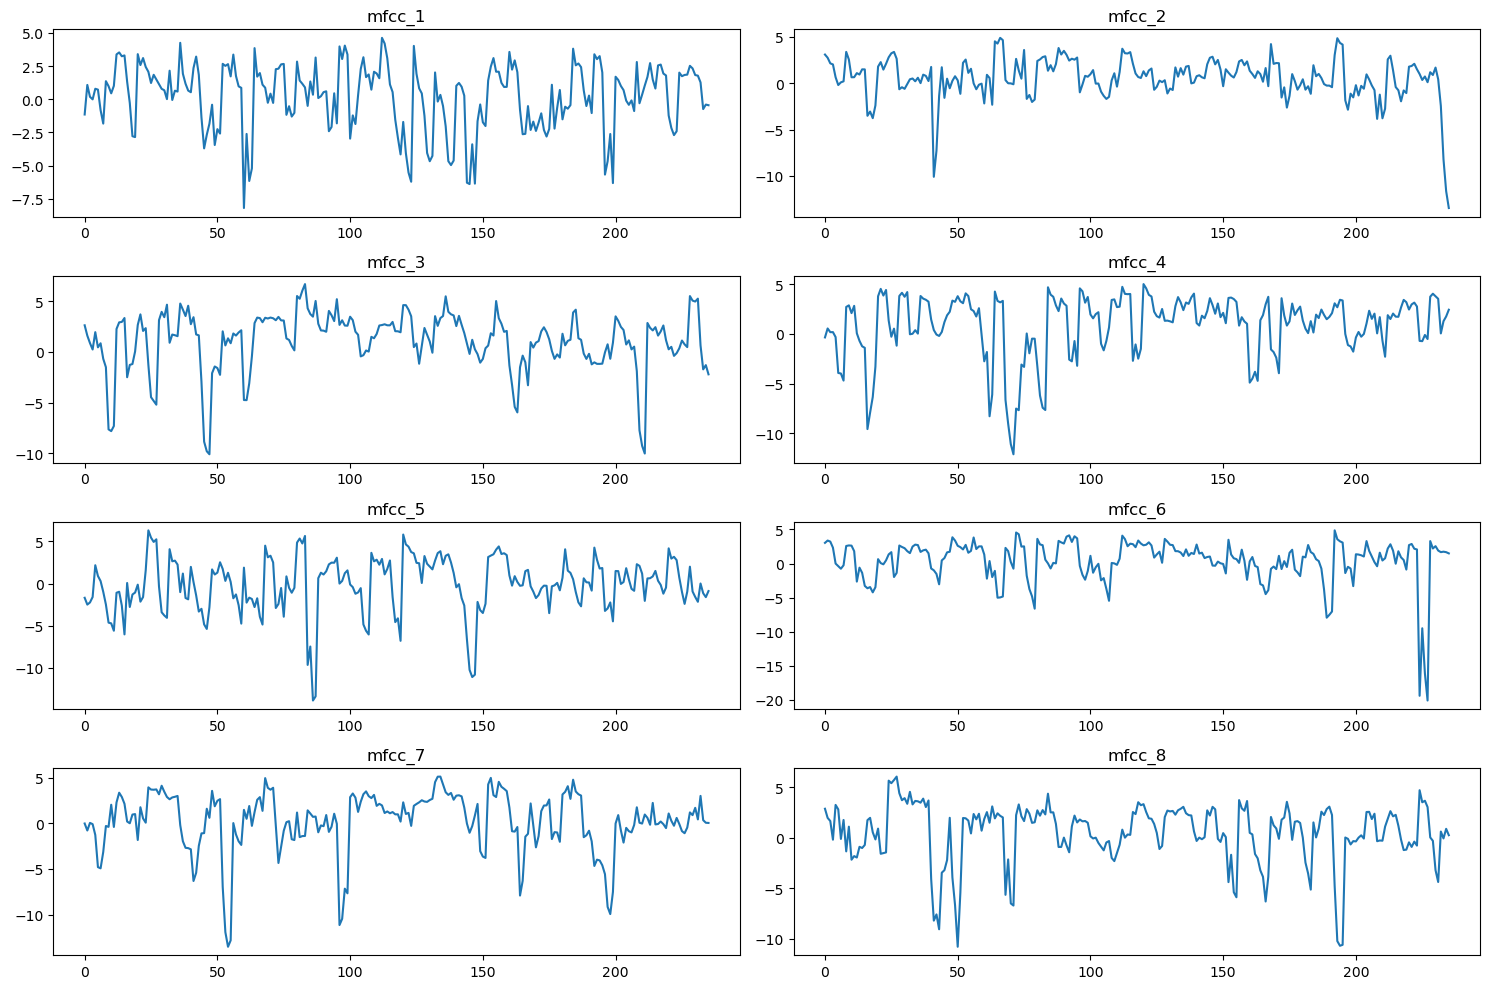

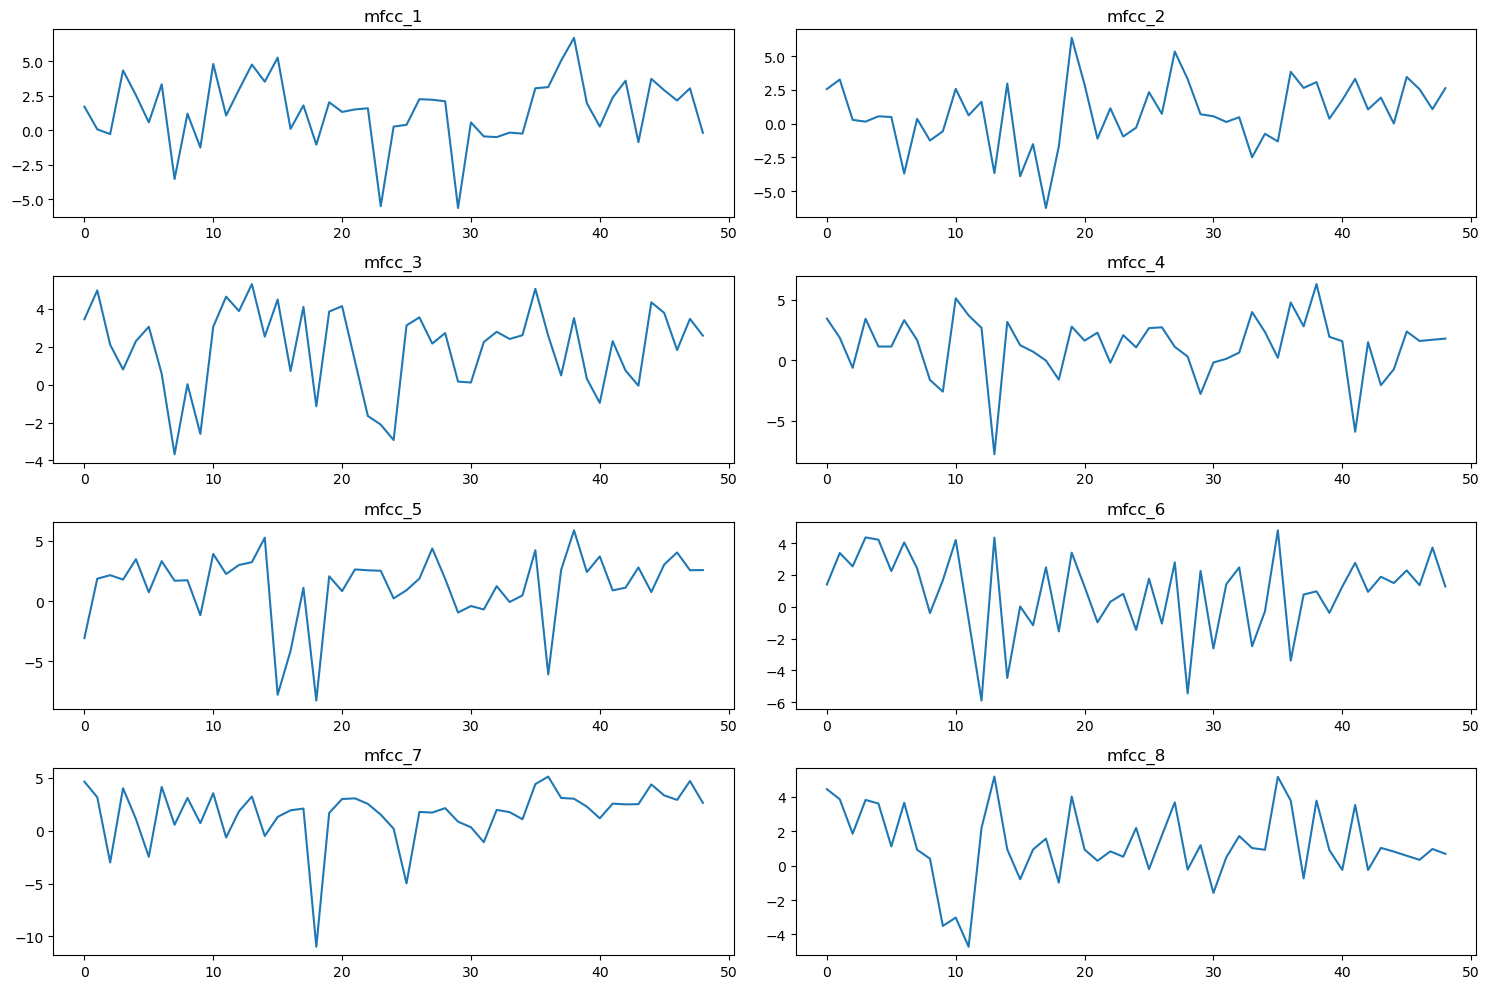

    patient_id AS AR MR MS  N  \
0  patient_052  0  1  0  0  0   
1  patient_052  0  1  0  0  0   
2  patient_052  0  1  0  0  0   
3  patient_052  0  1  0  0  0   
4  patient_058  0  1  0  0  0   

                                         recording_1  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e...   
1  [-0.008453369, -0.0070495605, -0.0056762695, -...   
2  [-0.07507324, -0.077178955, -0.07913208, -0.08...   
3  [0.18301392, 0.1817627, 0.1803894, 0.17889404,...   
4  [0.0, 0.0, 6.1035156e-05, 9.1552734e-05, 0.000...   

                                         recording_2  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e...   
1  [-0.04260254, -0.04196167, -0.04144287, -0.041...   
2  [-0.22476196, -0.21795654, -0.21099854, -0.203...   
3  [-0.1776123, -0.16983032, -0.16186523, -0.1537...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -6.1035156...   

                                         recording_3  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e-05, ...   
1  [0.140625, 0

In [23]:
# 6. mel-frequency cepstral coefficients (MFCCs) column for all the audio files
mfcc_list = []
plt.figure(figsize=(15, 10))

for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"mfcc_{i+1}"
    mfcc = []
    for aud in train_df[column_name]:
        # file_path = train_dir_path + audio_file + ".wav"
        # aud, sr = librosa.load(file_path, sr=None)
        mfcc.append(librosa.feature.mfcc(y=np.array(aud), sr=sr, n_mfcc=13).mean())
    mfcc_list.append(mfcc)
    train_df[new_column_name] = mfcc
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(mfcc)
    plt.tight_layout()
plt.show()

mfcc_list = []
plt.figure(figsize=(15, 10))

for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"mfcc_{i+1}"
    mfcc = []
    for audio_file in test_df[column_name]:
        file_path = test_dir_path + audio_file + ".wav"
        aud, sr = librosa.load(file_path, sr=None)
        mfcc.append(librosa.feature.mfcc(y=aud, sr=sr, n_mfcc=13).mean())
    mfcc_list.append(mfcc)
    test_df[new_column_name] = mfcc
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(mfcc)
    plt.tight_layout()
plt.show()

print(train_df.head())
print(test_df.head())

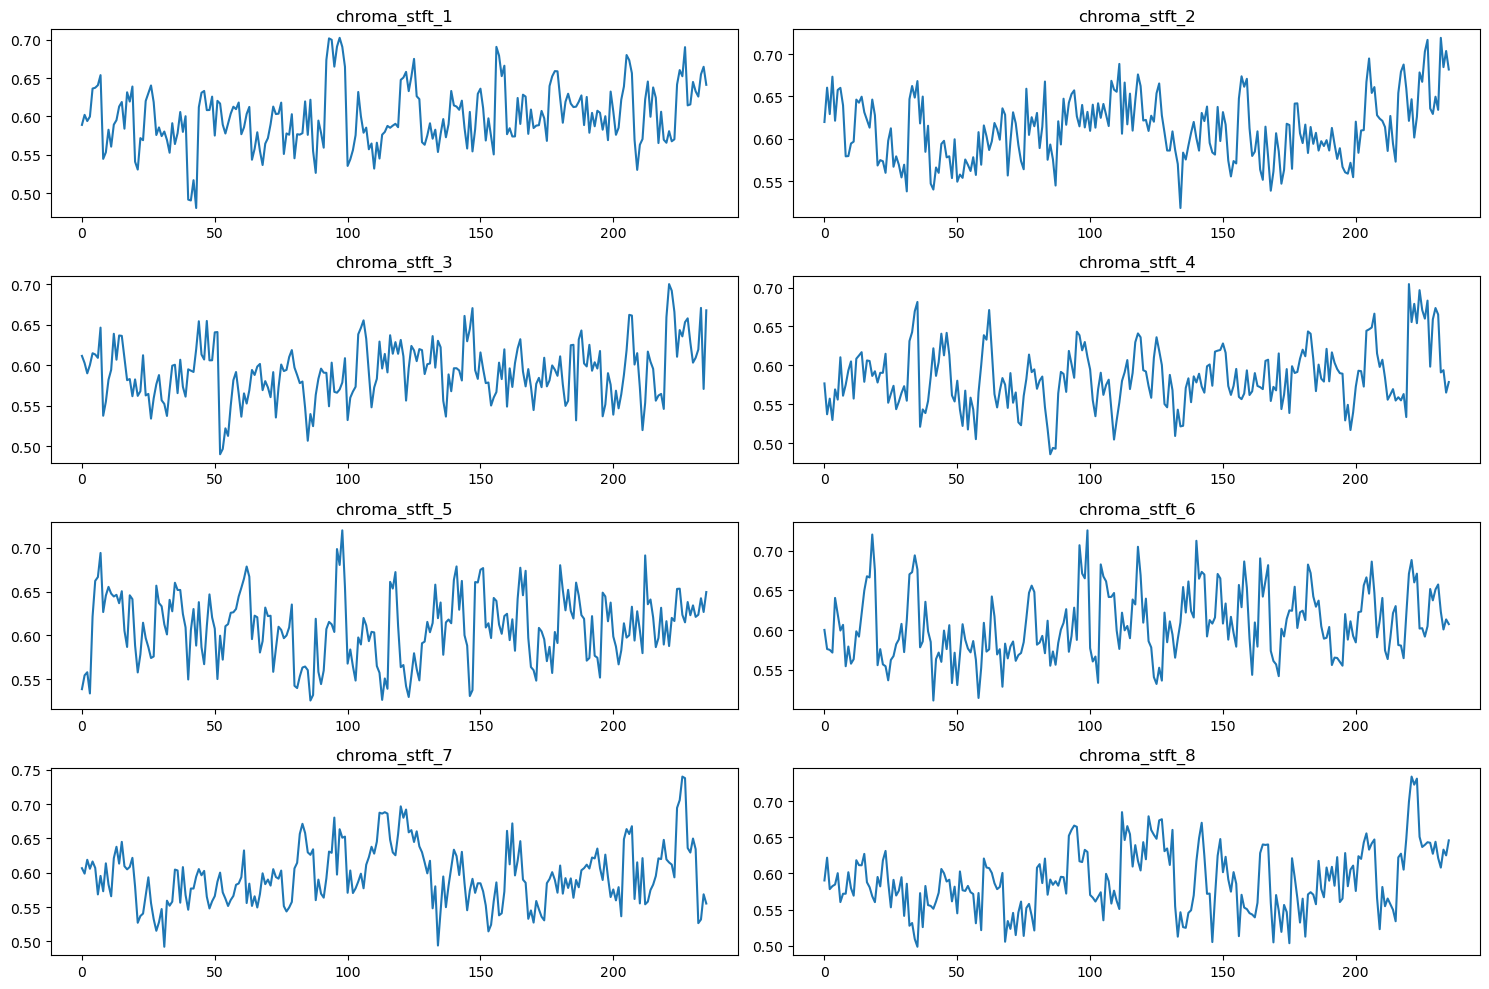

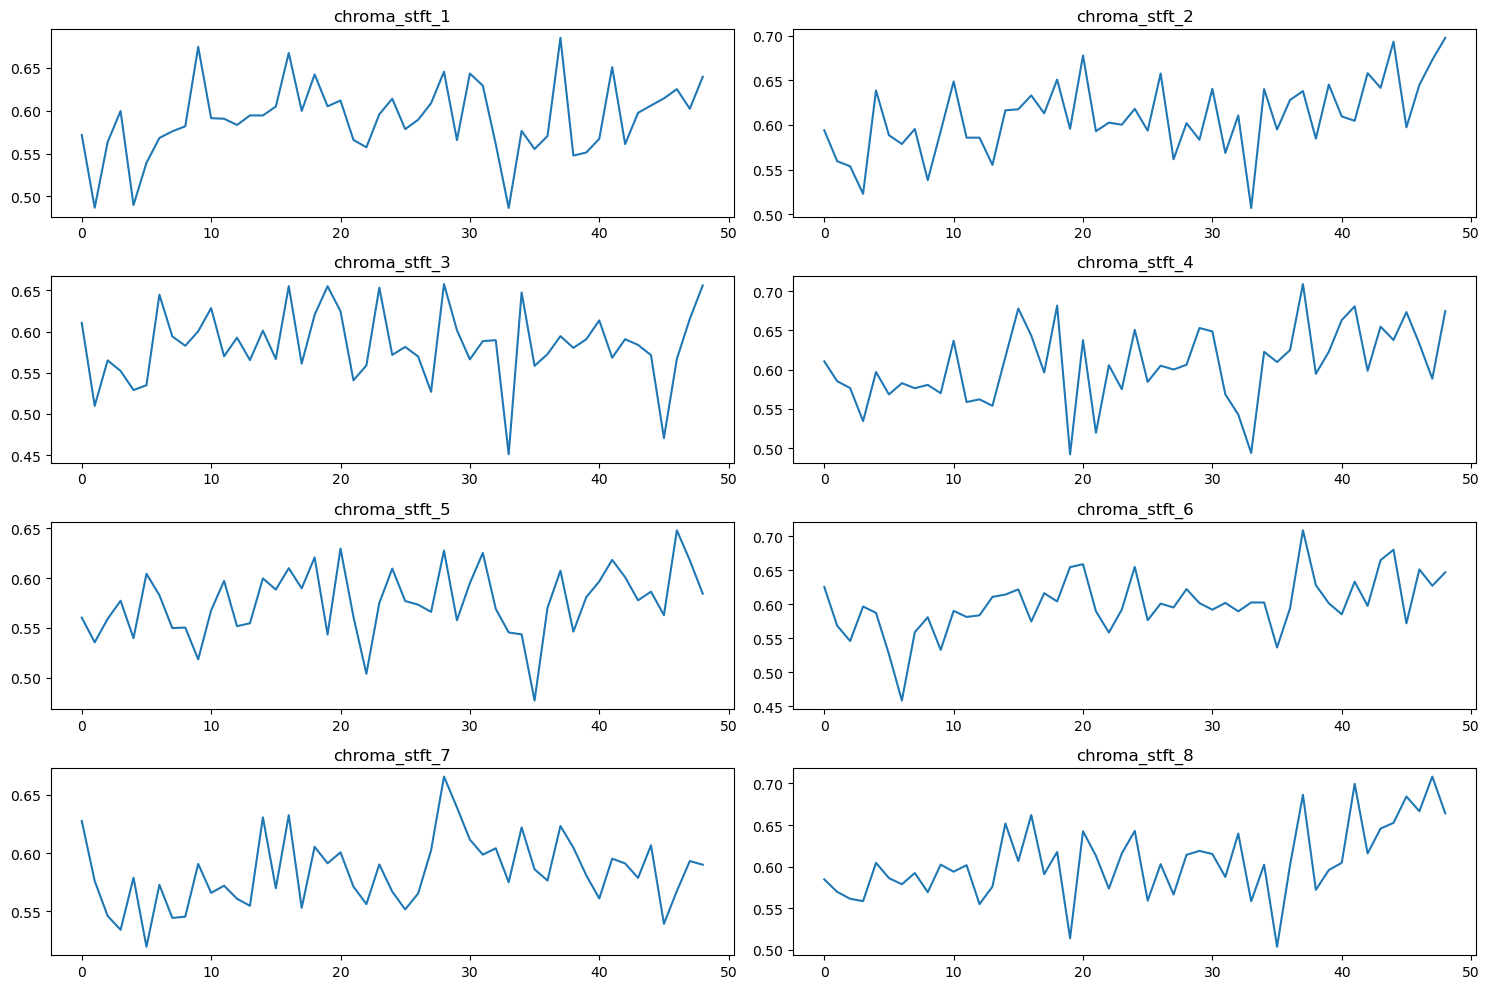

    patient_id AS AR MR MS  N  \
0  patient_052  0  1  0  0  0   
1  patient_052  0  1  0  0  0   
2  patient_052  0  1  0  0  0   
3  patient_052  0  1  0  0  0   
4  patient_058  0  1  0  0  0   

                                         recording_1  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e...   
1  [-0.008453369, -0.0070495605, -0.0056762695, -...   
2  [-0.07507324, -0.077178955, -0.07913208, -0.08...   
3  [0.18301392, 0.1817627, 0.1803894, 0.17889404,...   
4  [0.0, 0.0, 6.1035156e-05, 9.1552734e-05, 0.000...   

                                         recording_2  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e...   
1  [-0.04260254, -0.04196167, -0.04144287, -0.041...   
2  [-0.22476196, -0.21795654, -0.21099854, -0.203...   
3  [-0.1776123, -0.16983032, -0.16186523, -0.1537...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -6.1035156...   

                                         recording_3  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e-05, ...   
1  [0.140625, 0

In [24]:
# 7. chroma feature column for all the audio files
chroma_stft_list = []
plt.figure(figsize=(15, 10))

for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"chroma_stft_{i+1}"
    chroma_stft = []
    for aud in train_df[column_name]:
        # file_path = train_dir_path + audio_file + ".wav"
        # aud, sr = librosa.load(file_path, sr=None)
        chroma_stft.append(librosa.feature.chroma_stft(y=np.array(aud), sr=sr).mean())
    chroma_stft_list.append(chroma_stft)
    train_df[new_column_name] = chroma_stft
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(chroma_stft)
    plt.tight_layout()
plt.show()

chroma_stft_list = []
plt.figure(figsize=(15, 10))

for i in range(8):
    column_name = f"recording_{i+1}"
    new_column_name = f"chroma_stft_{i+1}"
    chroma_stft = []
    for audio_file in test_df[column_name]:
        file_path = test_dir_path + audio_file + ".wav"
        aud, sr = librosa.load(file_path, sr=None)
        chroma_stft.append(librosa.feature.chroma_stft(y=aud, sr=sr).mean())
    chroma_stft_list.append(chroma_stft)
    test_df[new_column_name] = chroma_stft
    plt.subplot(4, 2, i+1)
    plt.title(new_column_name)
    plt.plot(chroma_stft)
    plt.tight_layout()
plt.show()

print(train_df.head())
print(test_df.head())

In [25]:
# drop all the recording name columns from the train and test data
train_df.drop(columns=[f"recording_{i+1}" for i in range(8)], inplace=True)
test_df.drop(columns=[f"recording_{i+1}" for i in range(8)], inplace=True)

In [26]:
# split the train data into features and target
train_ids = train_df["patient_id"]
test_ids = test_df["patient_id"]
y = train_df[["AS", "AR", "MR", "MS", "N"]]
train_df = train_df.drop(columns=["patient_id", "AS", "AR", "MR", "MS", "N"])
X = train_df
test_df = test_df.drop(columns=["patient_id"])
Y = test_df
print(X.shape)
print(y.shape)
print(Y.shape)

(236, 56)
(236, 5)
(49, 56)


In [27]:
# save the train and test data to a temporary csv file
filename = "segmented_zero_centroid_rolloff_mfcc_chroma.csv"
train_filename = "segmented_zero_energy_amplitude_centroid_rolloff_mfcc_chroma_train.csv"
test_filename = "segmented_zero_energy_amplitude_centroid_rolloff_mfcc_chroma_test.csv"
# X.to_csv(train_filename, index=False)
# Y.to_csv(test_filename, index=False)

In [28]:
# load the train and test data
X = pd.read_csv(train_filename)
Y = pd.read_csv(test_filename)

In [29]:
y

AS AR MR MS  N
0    0  1  0  0  0
1    0  1  0  0  0
2    0  1  0  0  0
3    0  1  0  0  0
4    0  1  0  0  0
..  .. .. .. .. ..
231  0  0  0  1  0
232  0  0  0  1  0
233  0  0  0  1  0
234  0  0  0  1  0
235  0  0  0  1  0

[236 rows x 5 columns]

In [30]:
# make the y values into integer
y = y.astype(int)

In [31]:
# # plot the target label imbalance
# plt.figure(figsize=(15, 10))

# # check for target label imbalance
# for cls in y.columns:
#     print(f"{cls}: {y[cls].value_counts()}")
#     plt.subplot(2, 3, list(y.columns).index(cls)+1)
#     sns.countplot(x=cls, data=y)
#     plt.title(cls)
#     plt.tight_layout()
# plt.show()


In [32]:
# # normalize the data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# Y = scaler.transform(Y)


# # principal component analysis and dimensionality reduction
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)
# Y_pca = pca.transform(Y)

# # plot the pca
# plt.figure(figsize=(15, 10))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y["AS"], cmap="viridis", label="AS")
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y["AR"], cmap="viridis", label="AR")
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y["MR"], cmap="viridis", label="MR")
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y["MS"], cmap="viridis", label="MS")
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y["N"], cmap="viridis", label="N")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.legend()
# plt.tight_layout()
# plt.show()


### Decision Tree Validation Macro F1: 0.17627, 0.21355 / 0.244

In [33]:
# # normalize the data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# Y = scaler.transform(Y)


# # use a leave-one-out cross-validation
# from sklearn.model_selection import LeaveOneOut
# from sklearn.metrics import f1_score
# loo = LeaveOneOut()

# # create a decision tree classifier
# dt = DecisionTreeClassifier(random_state=42)

# # create a list to store the predictions
# accuracies = []
# # iterate over the leave-one-out cross-validation and plot the accuracy
# for train_index, test_index in loo.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     print(X_train.shape)
#     print(y_train.shape)
#     dt.fit(X_train, y_train)
#     y_pred = dt.predict(X_test)
#     print(f"true label: {y_test.values[0]}")
#     print(f"predicted label: {y_pred[0]}")
#     # calculate the f1 score
#     accuracies.append(f1_score(y_test, y_pred, average="macro"))
#     print(f"f1 score: {f1_score(y_test, y_pred, average='macro')}")
# print(f"mean f1 score: {np.mean(accuracies)}")
# # plot the f1 scores
# plt.plot(accuracies)
# plt.xlabel("Iteration")
# plt.ylabel("F1 Score")
# plt.title("F1 Score vs Iteration")

# # fit the model on the entire train data
# dt.fit(X, y)
# # make predictions on the test data
# test_preds = dt.predict(Y)
# # create a submission dataframe
# submission = pd.DataFrame(test_preds, columns=["AS", "AR", "MR", "MS", "N"])
# submission["patient_id"] = test_ids
# submission = submission[["patient_id", "AS", "AR", "MR", "MS", "N"]]
# # check the submission
# print(submission.head())


# # feature importance of the decision tree
# feature_importance = dt.feature_importances_
# # print all the feature importance and their corresponding column names
# print(feature_importance)
# print(train_df.columns)

# column_names = train_df.columns

# # plot the feature importance
# plt.figure(figsize=(15, 10))
# sns.barplot(x=feature_importance, y=column_names)
# plt.title("Feature Importance")
# plt.show()

# # select the top 35 features from the sorted values of the feature importance
# top_35_features = column_names[np.argsort(feature_importance)[::-1][:35]]
# # print the top 35 features and their importance values
# print(top_35_features)
# print(feature_importance[np.argsort(feature_importance)[::-1][:35]])

# # only keep these features in the train and test data
# X = train_df[top_35_features]
# Y = test_df[top_35_features]

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# Y = scaler.transform(Y)

# # use a leave-one-out cross-validation
# from sklearn.model_selection import LeaveOneOut
# from sklearn.metrics import f1_score
# loo = LeaveOneOut()

# # create a decision tree classifier
# dt = DecisionTreeClassifier(random_state=42)

# # create a list to store the predictions
# accuracies = []
# # iterate over the leave-one-out cross-validation and plot the accuracy
# for train_index, test_index in loo.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     dt.fit(X_train, y_train)
#     y_pred = dt.predict(X_test)
#     print(f"true label: {y_test.values[0]}")
#     print(f"predicted label: {y_pred[0]}")
#     # calculate the f1 score
#     accuracies.append(f1_score(y_test, y_pred, average="macro"))
#     print(f"f1 score: {f1_score(y_test, y_pred, average='macro')}")
# print(f"mean f1 score: {np.mean(accuracies)}")
# # plot the f1 scores
# plt.plot(accuracies)
# plt.xlabel("Iteration")
# plt.ylabel("F1 Score")
# plt.title("F1 Score vs Iteration")

# # fit the model on the entire train data
# dt.fit(X, y)
# # make predictions on the test data
# test_preds = dt.predict(Y)
# # create a submission dataframe
# submission = pd.DataFrame(test_preds, columns=["AS", "AR", "MR", "MS", "N"])
# submission["patient_id"] = test_ids
# submission = submission[["patient_id", "AS", "AR", "MR", "MS", "N"]]
# # check the submission
# print(submission.head())

In [34]:
# submission.to_csv("submission_dt_35_segmented_7_feat.csv", index=False) # 0.3853

### XGBoost Validation Macro F1: 0.186/0.227

In [35]:
# # use a leave-one-out cross-validation
# from sklearn.model_selection import LeaveOneOut
# from sklearn.metrics import f1_score
# loo = LeaveOneOut()

# # normalize the data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# Y = scaler.transform(Y)

# # try xtreme gradient boosting
# from xgboost import XGBClassifier
# xgb = XGBClassifier(random_state=42)

# # create a list to store the predictions
# accuracies = []
# # iterate over the leave-one-out cross-validation and plot the accuracy
# for train_index, test_index in loo.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     xgb.fit(X_train, y_train)
#     y_pred = xgb.predict(X_test)
#     print(f"true label: {y_test.values[0]}")
#     print(f"predicted label: {y_pred[0]}")
#     # calculate the f1 score
#     accuracies.append(f1_score(y_test, y_pred, average="macro"))
#     print(f"f1 score: {f1_score(y_test, y_pred, average='macro')}")

# print(f"mean f1 score: {np.mean(accuracies)}")
# # plot the f1 scores
# plt.plot(accuracies)
# plt.xlabel("Iteration")
# plt.ylabel("F1 Score")
# plt.title("F1 Score vs Iteration")
# plt.show()

# # feature importance of the xgboot classifier
# feature_importance = xgb.feature_importances_
# # print all the feature importance and their corresponding column names
# print(feature_importance)
# print(train_df.columns)

# column_names = train_df.columns

# # plot the feature importance
# plt.figure(figsize=(15, 10))
# sns.barplot(x=feature_importance, y=column_names)
# plt.title("Feature Importance")

# # select the top 30 features from the sorted values of the feature importance
# top_30_features = column_names[np.argsort(feature_importance)[::-1][:30]]
# # print the top 30 features and their importance values
# print(top_30_features)
# print(feature_importance[np.argsort(feature_importance)[::-1][:30]])

# # only keep these features in the train and test data
# X = train_df[top_30_features]
# Y = test_df[top_30_features]

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# Y = scaler.transform(Y)

# xgb = XGBClassifier(random_state=42)

# # use a leave-one-out cross-validation
# from sklearn.model_selection import LeaveOneOut
# from sklearn.metrics import f1_score
# loo = LeaveOneOut()

# # create a list to store the predictions
# accuracies = []
# # iterate over the leave-one-out cross-validation and plot the accuracy
# for train_index, test_index in loo.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     xgb.fit(X_train, y_train)
#     y_pred = xgb.predict(X_test)
#     print(f"true label: {y_test.values[0]}")
#     print(f"predicted label: {y_pred[0]}")
#     # calculate the f1 score
#     accuracies.append(f1_score(y_test, y_pred, average="macro"))
#     print(f"f1 score: {f1_score(y_test, y_pred, average='macro')}")

# print(f"mean f1 score: {np.mean(accuracies)}")
# # plot the f1 scores
# plt.plot(accuracies)
# plt.xlabel("Iteration")
# plt.ylabel("F1 Score")
# plt.title("F1 Score vs Iteration")
# plt.show()


In [36]:
# # fit the model on the entire train data
# xgb.fit(X, y)
# # make predictions on the test data
# test_preds = xgb.predict(Y)
# # create a submission dataframe
# submission = pd.DataFrame(test_preds, columns=["AS", "AR", "MR", "MS", "N"])
# submission["patient_id"] = test_ids
# submission = submission[["patient_id", "AS", "AR", "MR", "MS", "N"]]
# # check the submission
# print(submission.head())


In [37]:
# submission.to_csv("submission_xgb_30_segmented_7_feat.csv", index=False) # 0.3984

In [38]:
# # try random forest

# # normalize the data
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import f1_score
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# Y = scaler.transform(Y)

# rf = RandomForestClassifier(random_state=42, n_estimators=100)

# # use a leave-one-out cross-validation
# from sklearn.model_selection import LeaveOneOut
# loo = LeaveOneOut()

# # create a list to store the predictions
# accuracies = []
# # iterate over the leave-one-out cross-validation and plot the accuracy
# for train_index, test_index in loo.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     rf.fit(X_train, y_train)
#     y_pred = rf.predict(X_test)
#     print(f"true label: {y_test.values[0]}")
#     print(f"predicted label: {y_pred[0]}")
#     # calculate the f1 score
#     accuracies.append(f1_score(y_test, y_pred, average="macro"))
#     print(f"f1 score: {f1_score(y_test, y_pred, average='macro')}")

# print(f"mean f1 score: {np.mean(accuracies)}")
# # plot the f1 scores
# plt.plot(accuracies)
# plt.xlabel("Iteration")
# plt.ylabel("F1 Score")
# plt.title("F1 Score vs Iteration")



In [39]:
# # fit the model on the entire train data
# rf.fit(X, y)
# # make predictions on the test data
# test_preds = rf.predict(Y)
# # create a submission dataframe
# submission = pd.DataFrame(test_preds, columns=["AS", "AR", "MR", "MS", "N"])
# submission["patient_id"] = test_ids
# submission = submission[["patient_id", "AS", "AR", "MR", "MS", "N"]]
# # check the submission
# print(submission.head())

In [40]:
# # save the submission
# submission.to_csv("submission_rf_7_feat.csv", index=False)

In [41]:
# # apply complex multi-layer perceptron
# from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import LeaveOneOut
# from sklearn.metrics import f1_score

# # normalize the data
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# Y = scaler.transform(Y)

# # create a multi-layer perceptron classifier
# mlp = MLPClassifier(random_state=42, max_iter=100000)

# # use a leave-one-out cross-validation
# loo = LeaveOneOut()

# # create a list to store the predictions
# accuracies = []
# # iterate over the leave-one-out cross-validation and plot the accuracy

# for train_index, test_index in loo.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     mlp.fit(X_train, y_train)
#     y_pred = mlp.predict(X_test)
#     print(f"true label: {y_test.values[0]}")
#     print(f"predicted label: {y_pred[0]}")
#     # calculate the f1 score
#     accuracies.append(f1_score(y_test, y_pred, average="macro"))
#     print(f"f1 score: {f1_score(y_test, y_pred, average='macro')}")

# print(f"mean f1 score: {np.mean(accuracies)}")
# # plot the f1 scores
# plt.plot(accuracies)
# plt.xlabel("Iteration")
# plt.ylabel("F1 Score")
# plt.title("F1 Score vs Iteration")
# plt.show()

In [42]:
# # fit the model on the entire train data
# mlp.fit(X, y)
# # make predictions on the test data
# test_preds = mlp.predict(Y)
# # create a submission dataframe
# submission = pd.DataFrame(test_preds, columns=["AS", "AR", "MR", "MS", "N"])
# submission["patient_id"] = test_ids
# submission = submission[["patient_id", "AS", "AR", "MR", "MS", "N"]]
# # check the submission
# print(submission.head())

In [43]:
# save the submission
# submission.to_csv("submission_mlp_7_feat.csv", index=False) # 0.3984

NameError: name 'submission' is not defined

In [ ]:
# # handle the data imbalance using MLSMOTE for multi label classification
# from collections import Counter
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import SMOTENC

# # check the distribution of the target classes
# print(Counter(y["AS"]))
# print(Counter(y["AR"]))
# print(Counter(y["MR"]))
# print(Counter(y["MS"]))
# print(Counter(y["N"]))

# X_trains = []
# y_trains = []

# # X -> train features, y -> train target, Y -> test features

# for cls in target_classes:
#     smote = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 3, 4])
#     X_train_resampled, y_train_resampled = smote.fit_resample(X, y[cls])
#     print(f"resampled shape for {cls}: {X_train_resampled.shape}")
#     print(f"resampled target shape for {cls}: {y_train_resampled.shape}")
#     X_trains.append(X_train_resampled)
#     y_trains.append(y_train_resampled)


# # Now X_train_resampled and y_train_resampled contain the oversampled data for each label

# # check the distribution of the target classes
# print(Counter(y_trains[0]))
# print(Counter(y_trains[1]))
# print(Counter(y_trains[2]))
# print(Counter(y_trains[3]))
# print(Counter(y_trains[4]))


In [44]:
# # concatanate the train features and train labels csv into one
# new_csv = pd.concat([X, y], axis=1)
# # save the new csv
# new_csv.to_csv("train_features_labels.csv", index=False)